# Prototype - Adversarial Detector
---

## Load Required Model & Data

In [12]:
# load model
from tensorflow import keras

model_ids = keras.models.load_model('../../CICIDS2017/models/ids_dnn_poc.keras')
model_ids.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │         3,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            22 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,938 (62.26 KB)

 Trainable params: 5,312 (20.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,626 (41.51 KB)

In [2]:
# load data split
import pandas as pd

X_train = pd.read_csv("../../CICIDS2017/train_test_split/X_train_poc.csv")
y_train = pd.read_csv("../../CICIDS2017/train_test_split/y_train_poc.csv")

print(X_train.shape, y_train.shape)


(192037, 68) (192037, 2)


In [3]:
# POC: create smaller dataset
X_train = X_train[:50000]
y_train = y_train[:50000]

print(X_train.shape, y_train.shape)

(50000, 68) (50000, 2)


In [4]:
# load adversarail samples

X_train_adv_fgsm = pd.read_csv("../../CICIDS2017/adversarial_samples/X_train_adv_fgsm_poc_50000.csv")
# X_test_adv_hsj = pd.read_csv("../../CICIDS2017/adversarial_samples/X_test_adv_hsj_proto.csv")
# X_test_adv_cw = pd.read_csv("../../CICIDS2017/adversarial_samples/X_test_adv_cw_poc.csv")
print(X_train_adv_fgsm.shape)

(50000, 68)


In [5]:
# load explanations

shap_values_df = pd.read_csv("../../CICIDS2017/shap_values/shap_values_poc_train_50000.csv")
print(shap_values_df.shape)
adv_shap_values_fgsm_df = pd.read_csv("../../CICIDS2017/shap_values/adv_shap_values_fgsm_poc_train_50000.csv")
print(adv_shap_values_fgsm_df.shape)
# adv_shap_values_hsj_df = pd.read_csv("../../CICIDS2017/shap_values/adv_shap_values_hsj_proto.csv")
# print(adv_shap_values_hsj_df.shape)
# adv_shap_values_cw_df = pd.read_csv("../../CICIDS2017/shap_values/adv_shap_values_cw_poc.csv")
# print(adv_shap_values_cw_df.shape)

(50000, 68)
(50000, 68)


---
## First Stage

### Normal Prediction

In [6]:
y_pred = model_ids.predict(X_train)
y_pred_adv_fgsm = model_ids.predict(X_train_adv_fgsm)
# y_pred_adv_hsj = model_ids.predict(X_test_adv_hsj)
# y_pred_adv_cw = model_ids.predict(X_test_adv_cw)

# evaluate model
from sklearn.metrics import accuracy_score

print(f"Accuracy on test set: {accuracy_score(y_train, y_pred.round())*100:.2f}%")
print(f"Accuracy on adversarial samples (FGSM): {accuracy_score(y_train, y_pred_adv_fgsm.round())*100:.2f}%")
# print(f"Accuracy on adversarial samples (HSJ): {accuracy_score(y_test, y_pred_adv_hsj.round())*100:.2f}%")
# print(f"Accuracy on adversarial samples (CW): {accuracy_score(y_train, y_pred_adv_cw.round())*100:.2f}%")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 720us/step
Accuracy on test set: 99.66%
Accuracy on adversarial samples (FGSM): 27.77%


### Find Benign Explanations

In [7]:
import numpy as np

# convert to binary, 1 == benign, 0 == malicious -> easier to work on
y_train_binary = np.array(y_train).argmin(axis=1)
y_pred_binary = y_pred.argmin(axis=1)
adv_fgsm_pred_binary = y_pred_adv_fgsm.argmin(axis=1)
# adv_hsj_pred_binary = y_pred_adv_hsj.argmin(axis=1)
# adv_cw_pred_binary = y_pred_adv_cw.argmin(axis=1)

In [8]:
print(f"Correct Labels:                           {y_train_binary[:10]}")

# find indices of correctly classified benign samples
# correct_benign_classified_indices = np.where((y_test_binary == 1) & (y_pred_binary == 1))[0]
# print(f"Predicted Labels:                         {y_pred_binary[:10]}")
# print(f"Correctly classified benign samples:      {correct_benign_classified_indices[:10]}")

# find indices of adversarial samples that were classified as benign
# FGSM
adv_fgsm_benign_indices = np.where(adv_fgsm_pred_binary == 1)[0]
print(f"Predicted Labels (FGSM):                  {adv_fgsm_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_fgsm_benign_indices[:10]}")
# # HSJ
# adv_hsj_benign_indices = np.where(adv_hsj_pred_binary == 1)[0]
# print(f"Predicted Labels (HSJ):                   {adv_hsj_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_hsj_benign_indices[:10]}")
# CW
# adv_cw_benign_indices = np.where(adv_cw_pred_binary == 1)[0]
# print(f"Predicted Labels (CW):                    {adv_cw_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_cw_benign_indices[:10]}")

Correct Labels:                           [1 1 0 0 1 1 0 1 1 0]
Predicted Labels (FGSM):                  [0 0 1 1 1 0 1 0 1 1]
Adversarial samples classified as benign: [ 2  3  4  6  8  9 10 12 14 16]


---

## Build Detector

### Build Dataframe

In [9]:
print(f"Correct Labels:                           {y_train_binary[:10]}")

# find indices of correctly classified benign samples
correct_benign_classified_indices = np.where(y_pred_binary == 1)[0]
print(f"Predicted Labels:                         {y_pred_binary[:10]}")
print(f"Correctly classified benign samples:      {correct_benign_classified_indices[:10]}")

# find indices of adversarial samples that were classified as benign
# FGSM
adv_fgsm_benign_indices = np.where(adv_fgsm_pred_binary == 1)[0]
print(f"Predicted Labels (FGSM):                  {adv_fgsm_pred_binary[:10]}")
print(f"Adversarial samples classified as benign: {adv_fgsm_benign_indices[:10]}")
# # HSJ
# adv_hsj_benign_indices = np.where(adv_hsj_pred_binary == 1)[0]
# print(f"Predicted Labels (HSJ):                   {adv_hsj_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_hsj_benign_indices[:10]}")
# CW
# adv_cw_benign_indices = np.where(adv_cw_pred_binary == 1)[0]
# print(f"Predicted Labels (CW):                    {adv_cw_pred_binary[:10]}")
# print(f"Adversarial samples classified as benign: {adv_cw_benign_indices[:10]}")

Correct Labels:                           [1 1 0 0 1 1 0 1 1 0]
Predicted Labels:                         [1 1 0 0 1 1 0 1 1 0]
Correctly classified benign samples:      [ 0  1  4  5  7  8 11 12 13 14]
Predicted Labels (FGSM):                  [0 0 1 1 1 0 1 0 1 1]
Adversarial samples classified as benign: [ 2  3  4  6  8  9 10 12 14 16]


In [10]:
# get shap values for correctly classified benign samples
print("Correctly classified benign samples:")
shap_values_benign_df = shap_values_df.iloc[correct_benign_classified_indices]
print(shap_values_benign_df.shape)

# get shap values for adversarial samples classified as benign
# FGSM
print("Adversarial samples classified as benign (FGSM):")
adv_shap_values_fgsm_benign_df = adv_shap_values_fgsm_df.iloc[adv_fgsm_benign_indices]
print(adv_shap_values_fgsm_benign_df.shape)
# # HSJ
# print("Adversarial samples classified as benign (HSJ):")
# adv_shap_values_hsj_benign_df = adv_shap_values_hsj_df.iloc[adv_hsj_benign_indices]
# print(adv_shap_values_hsj_benign_df.shape)
# CW
# print("Adversarial samples classified as benign (CW):")
# adv_shap_values_cw_benign_df = adv_shap_values_cw_df.iloc[adv_cw_benign_indices]
# print(adv_shap_values_cw_benign_df.shape)

# build X
print("X:")
X = pd.concat([shap_values_benign_df, adv_shap_values_fgsm_benign_df], axis=0)
print(X.shape)

# build y 
# normal: [1, 0], adv: [0, 1]
print("y:")
y_normal = np.array([[1, 0]] * shap_values_benign_df.shape[0])
y_adv = np.array([[0, 1]] * (adv_shap_values_fgsm_benign_df.shape[0]))
print(y_normal.shape, y_adv.shape)
print(y_normal[0], y_adv[0])
y = np.concatenate([y_normal, y_adv], axis=0)
print(y.shape)

Correctly classified benign samples:
(25121, 68)
Adversarial samples classified as benign (FGSM):
(38921, 68)
X:
(64042, 68)
y:
(25121, 2) (38921, 2)
[1 0] [0 1]
(64042, 2)


### Normalization

In [11]:
# check for columns which contain only 0 values
print("Columns which contain only 0 values....")
zero_columns = X.columns[(X.sum() == 0)]
print(f"Zero Columns: {zero_columns}")
# drop columns with only 0 values
X.drop(columns=zero_columns, inplace=True)
print("Dropped Zero Columns....")
print(X.shape)

Columns which contain only 0 values....
Zero Columns: Index([], dtype='object')
Dropped Zero Columns....
(64042, 68)


In [13]:
from sklearn.preprocessing import MinMaxScaler
import joblib

print("No Normalization....")
print(X[[' Destination Port', ' Flow Duration', ' Total Fwd Packets']].head(2))

# min-max normalization
print("Min-Max Normalization....")
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X)

# Save the scaler
joblib.dump(min_max_scaler, "minmax_scaler.pkl")

min_max_norm_feature_df = pd.DataFrame(min_max_scaler.transform(X), columns=X.columns)
print(min_max_norm_feature_df.shape)

# use normalized data
X = min_max_norm_feature_df
print(X[[' Destination Port', ' Flow Duration', ' Total Fwd Packets']].head(2))

No Normalization....
   Destination Port  Flow Duration  Total Fwd Packets
0          -0.01253      -0.011564           0.001365
1          -0.00550      -0.005884           0.001749
Min-Max Normalization....
(64042, 68)
   Destination Port  Flow Duration  Total Fwd Packets
0          0.150395       0.226796           0.624216
1          0.160062       0.238911           0.625272


### Shuffle Data

In [14]:
# TODO: maybe not needed -> random_state in train-test-split
# shuffle both sets in the same way
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=31)

### Split Train/Test Set

In [15]:
from sklearn.model_selection import train_test_split
# spit data into train and test set

X_train_detector, X_test_detector, y_train_detector, y_test_detector = train_test_split(X, y, test_size=0.10, random_state=21)
print(X_train_detector.shape, X_test_detector.shape, y_train_detector.shape, y_test_detector.shape)

(57637, 68) (6405, 68) (57637, 2) (6405, 2)


### Create Validation Set

In [16]:
from sklearn.model_selection import train_test_split
print(X.shape, y.shape)

X_train_detector, X_val_detector, y_train_detector, y_val_detector = train_test_split(X_train_detector, y_train_detector, test_size=0.25, random_state=31)

print(f"Val Shapes: {X_val_detector.shape}, {y_val_detector.shape}")
print(f"Shapes: {X_train_detector.shape}, {y_train_detector.shape}")

(64042, 68) (64042, 2)
Val Shapes: (14410, 68), (14410, 2)
Shapes: (43227, 68), (43227, 2)


### Model Creation

In [17]:
# Create DNN model from tensorflow
import setuptools.dist # needed to avoid error
import tensorflow as tf
from tensorflow import keras

# keras model for handling one hot encoded labels -> needed for attack creation
model_explainer = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),  # Define input shape explicitly
    keras.layers.Dense(50, activation='relu'),  # Hidden layer
    keras.layers.Dense(30, activation='relu'),  # Hidden layer
    keras.layers.Dropout(0.2), # TODO: test
    keras.layers.Dense(10, activation='relu'),  # Hidden layer
    keras.layers.Dropout(0.2), # TODO: test
    keras.layers.Dense(y_train.shape[1], activation='softmax')  # Output layer with softmax for one-hot encoding
])
# set learning rate
opt = keras.optimizers.Adam(learning_rate=0.001)
# compile the keras model
model_explainer.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

### Model Training

In [18]:
# fit the keras model on the dataset
model_explainer.fit(X_train_detector, y_train_detector, validation_data=(X_val_detector, y_val_detector), epochs=10, batch_size=100)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7440 - loss: 0.5098 - val_accuracy: 0.9681 - val_loss: 0.0976
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9606 - loss: 0.1177 - val_accuracy: 0.9656 - val_loss: 0.0918
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9730 - loss: 0.0860 - val_accuracy: 0.9633 - val_loss: 0.0960
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9773 - loss: 0.0703 - val_accuracy: 0.9754 - val_loss: 0.0664
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9836 - loss: 0.0536 - val_accuracy: 0.9895 - val_loss: 0.0342
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9854 - loss: 0.0482 - val_accuracy: 0.9793 - val_loss: 0.0534
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9852 - loss: 0.0467 - val_accuracy: 0.9908 - val_loss: 0.0282
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9875 - loss: 0.0414 - val_accuracy: 0.

---
## Evaluation

In [19]:
y_pred_detector = model_explainer.predict(X_test_detector)
y_pred_detector = (y_pred_detector > 0.5)

y_test_detector_binary = np.array(y_test_detector).argmin(axis=1)
y_pred_detector_binary = y_pred_detector.argmin(axis=1)
print(y_test_detector_binary.shape, y_pred_detector_binary.shape)

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
(6405,) (6405,)


In [20]:
# print accuracy, precision, recall and f1-score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# print accuracy
print(f"Global Accuracy: {accuracy_score(y_test_detector, y_pred_detector)*100:.2f}%")

# precision, recall, f1-score
print(classification_report(y_test_detector, y_pred_detector, target_names=['NORMAL', 'ADVERSARIAL ATTACK']))

# print true positive rate, false positive rate, true negative rate, false negative rate
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test_detector_binary, y_pred_detector_binary).ravel()
print(f"True Negative Rate: {tn/(tn+fp)*100:.2f}%")
print(f"False Positive Rate: {fp/(tn+fp)*100:.2f}%")
print(f"True Positive Rate: {tp/(tp+fn)*100:.2f}%")
print(f"False Negative Rate: {fn/(tp+fn)*100:.2f}%")

Global Accuracy: 97.35%
                    precision    recall  f1-score   support

            NORMAL       0.94      1.00      0.97      2545
ADVERSARIAL ATTACK       1.00      0.96      0.98      3860

         micro avg       0.97      0.97      0.97      6405
         macro avg       0.97      0.98      0.97      6405
      weighted avg       0.98      0.97      0.97      6405
       samples avg       0.97      0.97      0.97      6405

True Negative Rate: 95.62%
False Positive Rate: 4.38%
True Positive Rate: 99.96%
False Negative Rate: 0.04%


In [21]:
# show number of false positives and false negatives
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")

False Positives: 169
False Negatives: 1


In [22]:
# show false positive samples
fp_indices = np.where((y_test_detector_binary == 0) & (y_pred_detector_binary == 1))[0]
print(fp_indices)
# show false negative samples
fn_indices = np.where((y_test_detector_binary == 1) & (y_pred_detector_binary == 0))[0]
print(fn_indices)

[  18   47   96  158  216  224  239  325  330  357  381  394  496  506
  575  590  643  649  653  750  760  837  863  869  874  970 1021 1044
 1087 1090 1131 1134 1136 1144 1166 1216 1220 1306 1358 1394 1404 1474
 1527 1571 1582 1652 1656 1758 1765 1771 1818 1849 1900 1917 1950 1969
 2009 2040 2056 2090 2134 2148 2201 2250 2261 2330 2344 2345 2366 2433
 2435 2495 2500 2532 2553 2584 2604 2717 2761 2879 2894 2898 2939 3016
 3019 3027 3066 3170 3175 3222 3232 3262 3423 3427 3451 3480 3494 3519
 3558 3559 3584 3636 3772 3776 3824 3859 3920 3928 3932 3934 3998 4018
 4057 4074 4087 4190 4204 4350 4393 4403 4567 4616 4758 4963 4992 5025
 5032 5045 5075 5087 5108 5133 5158 5178 5237 5362 5405 5503 5507 5522
 5556 5575 5582 5606 5652 5659 5669 5740 5860 5867 5942 5950 6004 6049
 6055 6098 6106 6109 6114 6143 6161 6194 6212 6224 6269 6290 6298 6353
 6384]
[1522]


---
## Store Model

In [ ]:
# save model
model_explainer.save('../../CICIDS2017/models/ids_explainer_poc_50000.keras')

---
## Explanations

In [24]:
import shap 

# init shap explainer
explainer = shap.Explainer(model_explainer, X_test_detector, feature_names=X_test_detector.columns)
shap_values = explainer(X_test_detector)

print(shap_values.shape)

PermutationExplainer explainer: 621it [00:42, 11.68it/s]                         

(620, 68, 2)


In [25]:
# convert shap values to correct format
print(shap_values.shape) # one shap value per feature per sample per class
shap_values = shap_values[:, :, 0] # 1 == Benign, 0 == Malicious
print(shap_values.shape) # one shap value per feature per sample

(620, 68, 2)
(620, 68)


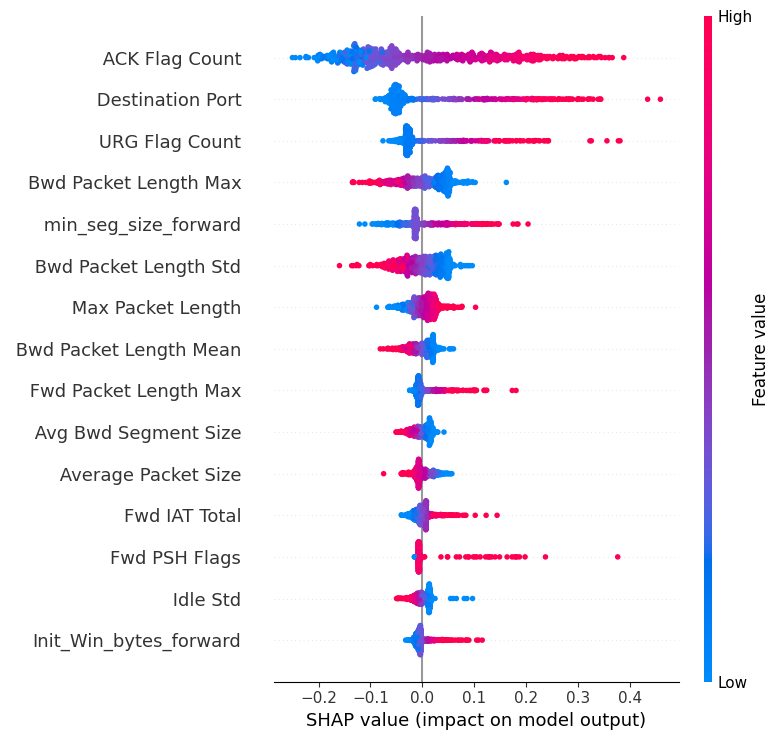

In [26]:
shap.summary_plot(shap_values, X_test_detector, max_display=15)